In [1]:
# https://arxiv.org/abs/cond-mat/0703314
# https://arxiv.org/abs/0808.3779

# https://github.com/scipy/scipy/issues/7151
# https://apps.dtic.mil/sti/pdfs/AD1004183.pdf
# https://www.codeproject.com/Articles/21282/Compute-Permanent-of-a-Matrix-with-Ryser-s-Algorit

# https://rosettacode.org/wiki/Determinant_and_permanent
# https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible

# https://stackoverflow.com/questions/38738835/generating-gray-codes
# https://qiita.com/b1ueskydragon/items/75cfee42541ea723080c

# https://qiita.com/phdax/items/3064de264c7933bab2f5
# https://web.archive.org/web/20190108235115/https://www.hackersdelight.org/hdcodetxt/pop.c.txt
# http://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetParallel
# https://stackoverflow.com/questions/9829578/fast-way-of-counting-non-zero-bits-in-positive-integer

# https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time

In [3]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [4]:
@jit(nopython=True)
def calc_eks_xkrs(L,J,W,rnd,alpha=1e11):
    ham = np.zeros((L,L),dtype=np.float64)
    for i in range(L):
        ham[i,i] = W*(2.0*rnd[i]-1.0)
    if alpha > 1e10:
        for i in range(L-1):
            ham[i,i+1] = -J
            ham[i+1,i] = -J
    else:
        ## - \sum_{i<j} J_{ij} ( c^{\dagger}_i c_j + c^{\dagger}_j c_i )
        for i in range(L):
            for j in range(i+1,L):
                if i!=j:
                    tmp = -J/(np.abs(i-j))**alpha
                    ham[i,j] = tmp
                    ham[j,i] = tmp
        ## equivalent form
        # for i in range(L):
        #     for j in range(L):
        #         if i!=j:
        #             ham[i,j] = -J/(np.abs(i-j))**alpha
    #print(ham)
    eks, xkrs = np.linalg.eigh(ham)
    return eks, xkrs

# @jit(nopython=True)
# def calc_rsks(L):
#     rs = np.arange(1,L+1) ## from 1 to L
#     ks = np.linspace(np.pi/(L+1.0),L*np.pi/(L+1.0),L)
#     return rs,ks

# @jit(nopython=True)
# def calc_eks(J,ks):
#     return -2.0*J*np.cos(ks)

# @jit(nopython=True)
# def calc_xkrs(L,ks,rs):
#     return np.sqrt(2.0/(L+1.0))*np.sin(np.outer(ks,rs))

@jit(nopython=True)
def calc_ys(t,eks,xkrs):
    xc = (1.0+0.0j)*xkrs # for numba
    expeks = np.diag(np.exp(1j*t*eks))
#    return xc @ expeks @ xc
    return xc @ expeks @ xc.T

# @jit(nopython=True)
# def calc_fs(ys,system):
#     diag = (1.0+0.0j)*np.diag(system)
#     return ys @ diag @ ys.T.conjugate()

@jit(nopython=True)
def calc_fs_cdw(ys,system,period=1):
    diag = (1.0+0.0j)*np.diag(system)
    ycuts = np.copy(ys[::period,:]) ## avoid NumbaPerformanceWarning to make contiguous arrays by deep copy
#    ycuts = ys[::period,:]
    return ycuts @ diag @ ycuts.T.conjugate()

@jit(nopython=True)
def calc_z(L,system,t,eks,xkrs,period=1):
    ys = calc_ys(t,eks,xkrs)
#    fs = calc_fs(ys,system)
    fs = calc_fs_cdw(ys,system,period=period)
    dlt = np.eye(fs.shape[0],dtype=np.complex128)
    return np.vstack( (np.hstack((fs,dlt-fs)), np.hstack((dlt-fs,fs))) )

@jit(nopython=True)
def get_dat(L,system,J,ts,W,rnd,alpha=1e11,period=1):
    # rs, ks = calc_rsks(L)
    # eks = calc_eks(J,ks)
    # xkrs = calc_xkrs(L,ks,rs)    
    eks, xkrs = calc_eks_xkrs(L,J,W,rnd,alpha=alpha)
    data = np.zeros((len(ts),2),dtype=np.float64)
    for i,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period=period)
        data[i] = np.array([t,-np.log(perm_bbfg(matz).real)])
    return data

In [5]:
L = 5
seed = 12345

## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
rng = np.random.default_rng(seed)
rnd = rng.random(L)

print(rnd)
print(type(rnd[0]))

J = 1.0
W = 20.0
eks, xkrs = calc_eks_xkrs(L,J,W,rnd)

eks, xkrs = calc_eks_xkrs(L,J,W,rnd,alpha=2.0)

[0.22733602 0.31675834 0.79736546 0.67625467 0.39110955]
<class 'numpy.float64'>


L,calctime: 4 5.734471797943115
L,calctime: 6 0.017103910446166992
L,calctime: 8 0.33382725715637207
L,calctime: 10 6.743483066558838


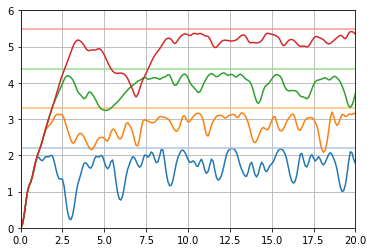

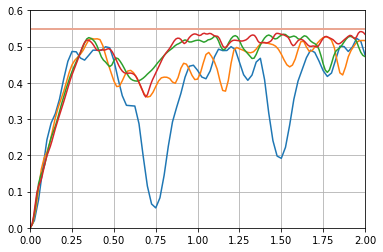

In [6]:
## Mott insulator initial

period = 1
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,6)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
    plt.plot([np.min(ts),np.max(ts)],[np.log(3.0)*0.5*L,np.log(3.0)*0.5*L],color=cmap(2*i+1))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.6)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
    plt.plot([np.min(ts)/L,np.max(ts)/L],[np.log(3.0)*0.5,np.log(3.0)*0.5],color=cmap(2*i+1))
plt.show()

L,calctime: 4 0.0014269351959228516
L,calctime: 6 0.0015780925750732422
L,calctime: 8 0.00215911865234375
L,calctime: 10 0.00487208366394043
L,calctime: 12 0.01854419708251953
L,calctime: 14 0.07612109184265137
L,calctime: 16 0.3366379737854004
L,calctime: 18 1.5104358196258545
L,calctime: 20 6.786361932754517


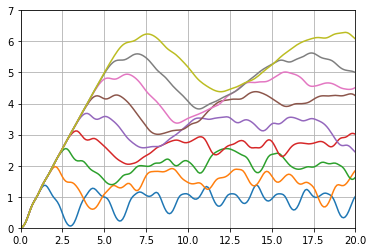

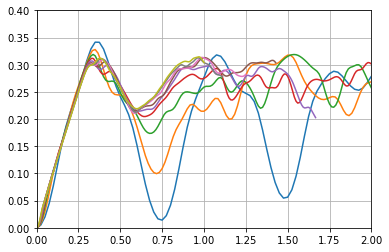

In [7]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 6 0.0015881061553955078
L,calctime: 12 0.0027129650115966797
L,calctime: 18 0.01961207389831543
L,calctime: 24 0.3465099334716797
L,calctime: 30 7.680430889129639


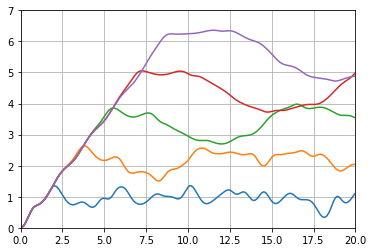

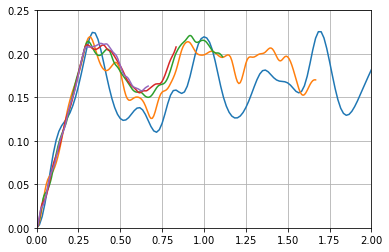

In [8]:
## CDW 001001001... initial

period = 3
J = 1.0
ts = np.linspace(0,20,201)
Ls = [6,12,18,24,30]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.25)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 4 1.482112169265747
L,calctime: 6 0.0014641284942626953
L,calctime: 8 0.002090930938720703
L,calctime: 10 0.004477024078369141
L,calctime: 12 0.017416954040527344
L,calctime: 14 0.07951092720031738
L,calctime: 16 0.35816097259521484
L,calctime: 18 1.563960075378418
L,calctime: 20 7.067833185195923


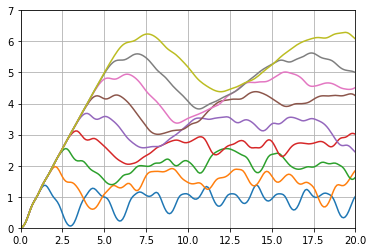

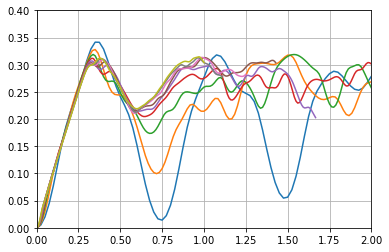

In [9]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0
alpha = 1e11

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,alpha=alpha,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 4 0.0012311935424804688
L,calctime: 6 0.0013880729675292969
L,calctime: 8 0.0020227432250976562
L,calctime: 10 0.0047740936279296875
L,calctime: 12 0.018349170684814453
L,calctime: 14 0.08110213279724121
L,calctime: 16 0.35544490814208984
L,calctime: 18 1.5507116317749023
L,calctime: 20 6.87204909324646


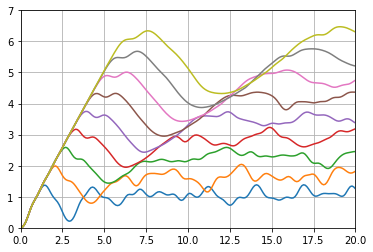

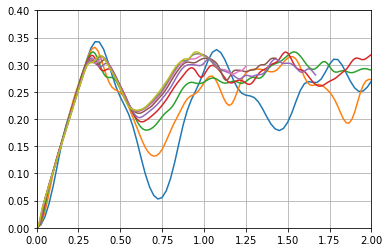

In [10]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0
alpha = 4.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,alpha=alpha,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 4 0.0012319087982177734
L,calctime: 6 0.001390695571899414
L,calctime: 8 0.001990079879760742
L,calctime: 10 0.005166053771972656
L,calctime: 12 0.018492937088012695
L,calctime: 14 0.07749581336975098
L,calctime: 16 0.342710018157959
L,calctime: 18 1.528076171875
L,calctime: 20 6.828143119812012


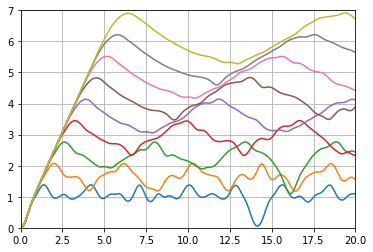

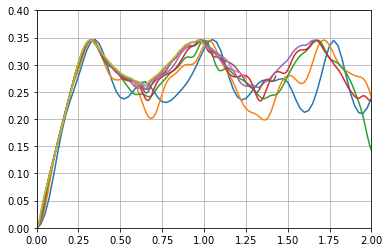

In [11]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0
alpha = 2.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,alpha=alpha,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 4 0.001241922378540039
L,calctime: 6 0.0014269351959228516
L,calctime: 8 0.002138853073120117
L,calctime: 10 0.004739999771118164
L,calctime: 12 0.017745018005371094
L,calctime: 14 0.07542014122009277
L,calctime: 16 0.34618282318115234
L,calctime: 18 1.504852056503296
L,calctime: 20 6.811984062194824


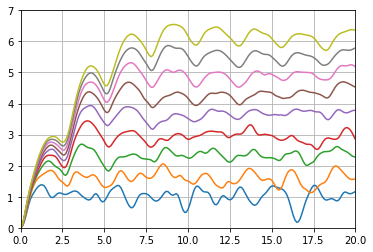

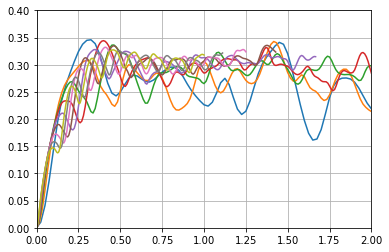

In [12]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 0.0
alpha = 1.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,alpha=alpha,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 4 0.0014159679412841797
L,calctime: 6 0.0013802051544189453
L,calctime: 8 0.002023935317993164
L,calctime: 10 0.0047681331634521484
L,calctime: 12 0.018066883087158203
L,calctime: 14 0.07669305801391602
L,calctime: 16 0.3492259979248047
L,calctime: 18 1.5201349258422852
L,calctime: 20 6.773935079574585


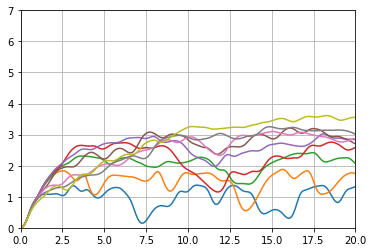

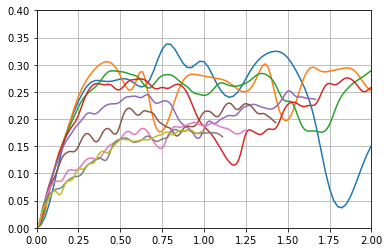

In [13]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 2.0
alpha = 1e11

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,alpha=alpha,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()

L,calctime: 4 0.0012559890747070312
L,calctime: 6 0.0013802051544189453
L,calctime: 8 0.002062082290649414
L,calctime: 10 0.004716157913208008
L,calctime: 12 0.018098115921020508
L,calctime: 14 0.07535624504089355
L,calctime: 16 0.3367726802825928
L,calctime: 18 1.5016860961914062
L,calctime: 20 6.713667154312134


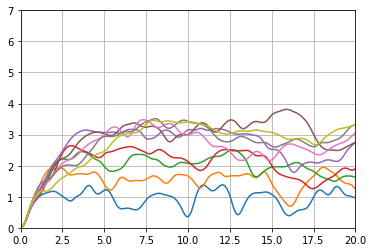

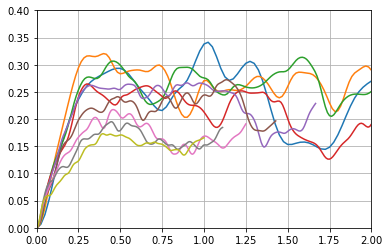

In [14]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
Ls = [4,6,8,10,12,14,16,18,20]
## https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
seed = 12345
rng = np.random.default_rng(seed)
rnd = rng.random(L)
W = 2.0
alpha = 2.0

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
    datas[i] = get_dat(L,system,J,ts,W,rnd,alpha=alpha,period=period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,20)
plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0],datas[i,:,1],color=cmap(2*i+0))
plt.show()

cmap = plt.get_cmap("tab20")
plt.xlim(0,2)
plt.ylim(0,0.4)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas[i,:,0]/L,datas[i,:,1]/L,color=cmap(2*i+0))
plt.show()